In [1]:
import xarray as xr
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import math

import torch.nn as nn
import torch.nn.functional as F

import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import plotly
import plotly.express as px
import datetime

import plotly.graph_objects as go
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import shap
from datetime import datetime

In [2]:
from pathlib import Path

DIRPATH= str(Path.cwd().parents[1])

module_path = DIRPATH + "/src"
if module_path not in sys.path:
    sys.path.append(module_path)
from utils.eem2020 import load_NWP, load_wind_power, load_max_power, load_turbine_map, load_wind_power_TS

In [3]:
df_2000 = pd.read_csv(DIRPATH + "/reports/results/results_DenseNet100_BC_qrf_2000.csv", index_col=0)
df_task1 = pd.read_csv(DIRPATH + "/reports/results/results_DenseNet100_BC_qrf_task1.csv", index_col=0)
df_task2 = pd.read_csv(DIRPATH + "/reports/results/results_DenseNet100_BC_qrf_task2.csv", index_col=0)
df_task3 = pd.read_csv(DIRPATH + "/reports/results/results_DenseNet100_BC_qrf_task3.csv", index_col=0)
df_task4 = pd.read_csv(DIRPATH + "/reports/results/results_DenseNet100_BC_qrf_task4.csv", index_col=0)
df_task5 = pd.read_csv(DIRPATH + "/reports/results/results_DenseNet100_BC_qrf_task5.csv", index_col=0)

In [4]:
df_2000["time"] = pd.to_datetime(df_2000[["year","month","day","hour"]])
df_task1["time"] = pd.to_datetime(df_task1[["year","month","day","hour"]])
df_task2["time"] = pd.to_datetime(df_task2[["year","month","day","hour"]])
df_task3["time"] = pd.to_datetime(df_task3[["year","month","day","hour"]])
df_task4["time"] = pd.to_datetime(df_task4[["year","month","day","hour"]])
df_task5["time"] = pd.to_datetime(df_task5[["year","month","day","hour"]])

In [5]:
df_2000 = df_2000[df_2000["time"]<"2001-03-01"]
df_task1 = df_task1[("2001-03-01"<=df_task1["time"]) & (df_task1["time"] <"2001-05-01")]
df_task2 = df_task2[("2001-05-01"<=df_task2["time"]) & (df_task2["time"] <"2001-07-01")]
df_task3 = df_task3[("2001-07-01"<=df_task3["time"]) & (df_task3["time"] <"2001-09-01")]
df_task4 = df_task4[("2001-09-01"<=df_task4["time"]) & (df_task4["time"] <"2001-11-01")]
df_task5 = df_task5[("2001-11-01"<=df_task5["time"])]
df = pd.concat([df_2000, df_task1, df_task2, df_task3, df_task4, df_task5],0)

In [6]:
df_honest = df.drop(columns=["pred_q" + str((i+1)*10) + "_" + type for type in ["conformal", "val"] for i in range(9)])
df_conformal = df.drop(columns=["pred_q" + str((i+1)*10) + "_" + type for type in ["honest", "val"] for i in range(9)])
df_val = df.drop(columns=["pred_q" + str((i+1)*10) + "_" + type for type in ["conformal", "honest"] for i in range(9)])

In [7]:
df_honest.rename(columns={"pred_q10_honest":"pred_10", "pred_q20_honest":"pred_20", "pred_q30_honest":"pred_30",
                               "pred_q40_honest":"pred_40", "pred_q50_honest":"pred_50", "pred_q60_honest":"pred_60",
                               "pred_q70_honest":"pred_70", "pred_q80_honest":"pred_80", "pred_q90_honest":"pred_90"}, 
                      inplace = True)
df_conformal.rename(columns={"pred_q10_conformal":"pred_10", "pred_q20_conformal":"pred_20", "pred_q30_conformal":"pred_30",
                                  "pred_q40_conformal":"pred_40", "pred_q50_conformal":"pred_50", "pred_q60_conformal":"pred_60",
                                  "pred_q70_conformal":"pred_70", "pred_q80_conformal":"pred_80", "pred_q90_conformal":"pred_90"},
                         inplace = True)
df_val.rename(columns={"pred_q10_val":"pred_10", "pred_q20_val":"pred_20", "pred_q30_val":"pred_30",
                            "pred_q40_val":"pred_40", "pred_q50_val":"pred_50", "pred_q60_val":"pred_60",
                            "pred_q70_val":"pred_70", "pred_q80_val":"pred_80", "pred_q90_val":"pred_90"},
                   inplace = True)

In [8]:
def generate_empirical_coverage(df_prob_method):
    empirical_cov = np.zeros(9)
    for i in range(1,10):
        empirical_cov[i-1] = np.sum(df_prob_method["pred_"+str(i*10)] >= df_prob_method["y"]*df_prob_method["max_power"])/len(df_prob_method)
    return empirical_cov

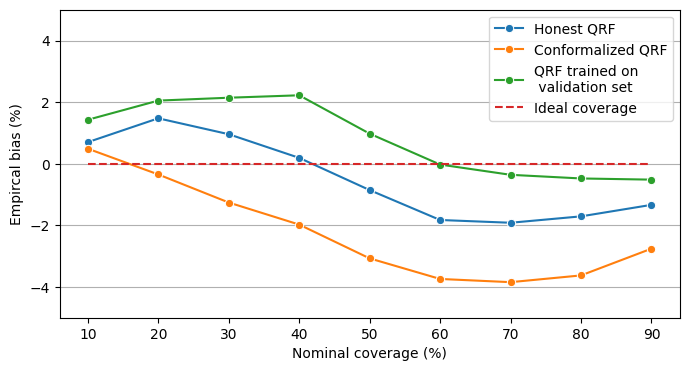

In [20]:
ideal_coverage = [i*10 for i in range(1,10)]
empirical_coverage_honest = generate_empirical_coverage(df_honest)*100
empirical_coverage_conformal = generate_empirical_coverage(df_conformal)*100
empirical_coverage_val  = generate_empirical_coverage(df_val)*100
    
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.lineplot(x=ideal_coverage, y=empirical_coverage_honest-ideal_coverage, marker="o", label="Honest QRF")
ax = sns.lineplot(x=ideal_coverage, y=empirical_coverage_conformal-ideal_coverage, marker="o", label="Conformalized QRF")
ax = sns.lineplot(x=ideal_coverage, y=empirical_coverage_val-ideal_coverage, marker="o", label="QRF trained on \n validation set")
ax = sns.lineplot(x=ideal_coverage, y=np.zeros(9), label="Ideal coverage", linestyle="--")
plt.ylim(-5,5)
plt.legend()
plt.grid(axis='y')
plt.ylabel("Empircal bias (%)")
plt.xlabel("Nominal coverage (%)")
fig.savefig(DIRPATH + "/reports/plots/nominal_coverage_emp_bias_qrf_methods.pdf")